<a href="https://colab.research.google.com/github/Rwolste/DS-3001-Assignments/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

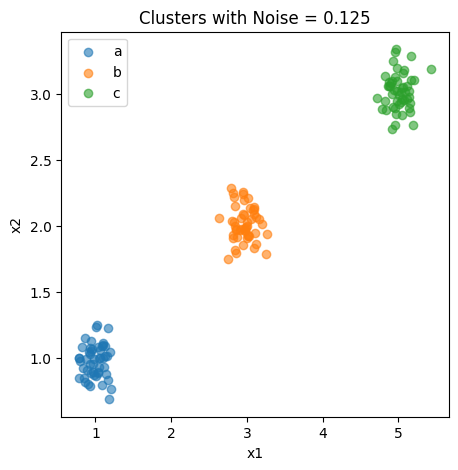

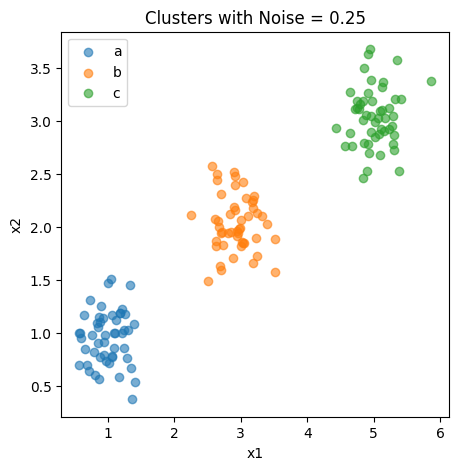

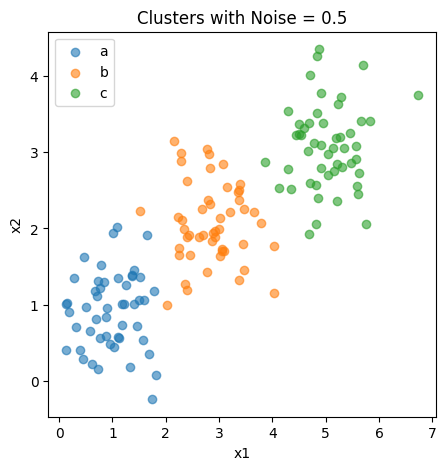

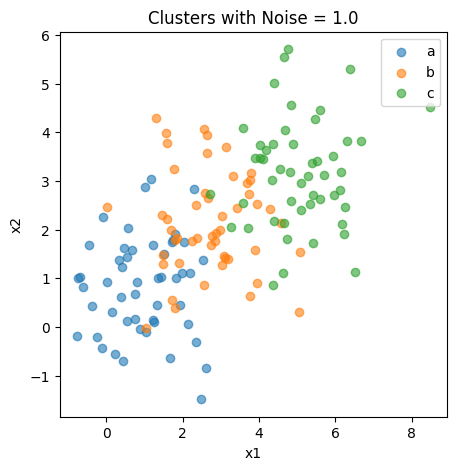

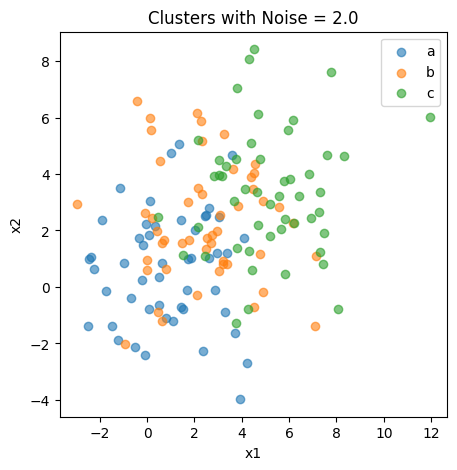

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create data with noise
def createData(noise, N=50):
    np.random.seed(100)  # Set the seed for replicability
    # Generate (x1, x2, g) triples:
    X1 = np.array([np.random.normal(1, noise, N), np.random.normal(1, noise, N)])
    X2 = np.array([np.random.normal(3, noise, N), np.random.normal(2, noise, N)])
    X3 = np.array([np.random.normal(5, noise, N), np.random.normal(3, noise, N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1': X1[0, :], 'x2': X1[1, :], 'group': 'a'})
    gdf2 = pd.DataFrame({'x1': X2[0, :], 'x2': X2[1, :], 'group': 'b'})
    gdf3 = pd.DataFrame({'x1': X3[0, :], 'x2': X3[1, :], 'group': 'c'})
    df = pd.concat([gdf1, gdf2, gdf3], axis=0)
    return df

# Creating datasets with different noise levels
df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

# Plotting function
def plot_clusters(df, noise_level):
    plt.figure(figsize=(5, 5))
    groups = df.groupby('group')
    for name, group in groups:
        plt.scatter(group.x1, group.x2, label=name, alpha=0.6)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"Clusters with Noise = {noise_level}")
    plt.legend()
    plt.show()

# Generate scatterplots for each dataset
for noise, df in zip([0.125, 0.25, 0.5, 1.0, 2.0], [df0_125, df0_25, df0_5, df1_0, df2_0]):
    plot_clusters(df, noise)


As the noise goes up the visual distinctness of the clusters go down drastically as the clusters begin to blend together.

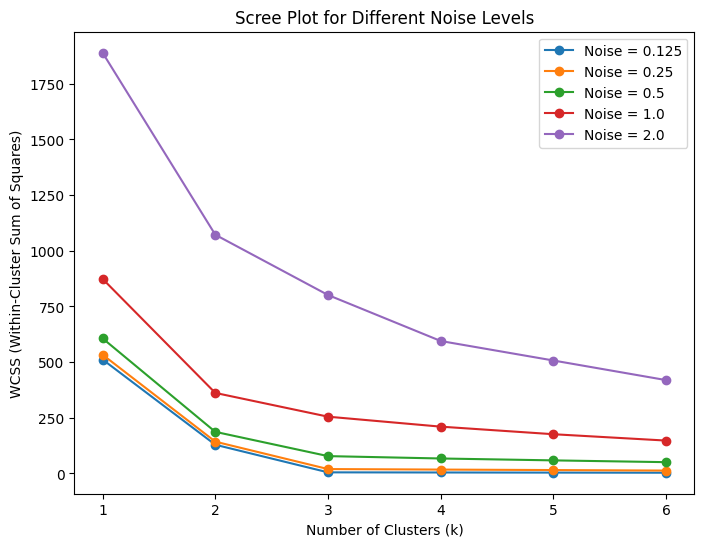

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to compute within-cluster sum of squares (WCSS)
def compute_wcss_fast(df):
    X = df[['x1', 'x2']].values  # Extract features
    wcss = []
    k_values = range(1, 7)  # Reduce max clusters to 6 for efficiency
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=100, n_init=3, max_iter=50)  # Reduce iterations
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    return k_values, wcss

# Assuming datasets df0_125, df0_25, df0_5, df1_0, df2_0 are already created
scree_data = {}
for noise, df in zip([0.125, 0.25, 0.5, 1.0, 2.0], [df0_125, df0_25, df0_5, df1_0, df2_0]):
    scree_data[noise] = compute_wcss_fast(df)

# Plot all scree plots in one figure
plt.figure(figsize=(8, 6))
for noise, (k_vals, wcss_vals) in scree_data.items():
    plt.plot(k_vals, wcss_vals, marker='o', label=f"Noise = {noise}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Scree Plot for Different Noise Levels")
plt.legend()
plt.show()

As noise increases, the distinct separation between clusters diminishes, causing a more gradual WCSS decline. The "elbow" is most visible at lower noise levels, allowing for a clear choice of k.At higher noise levels, selecting k becomes ambiguous, requiring additional methods to aid in the decision.

The Elbow Method is used to determine the optimal number of clusters (k) by analyzing the Within-Cluster Sum of Squares (WCSS), which measures how compact the clusters are. As k increases, the total WCSS decreases because adding more clusters reduces the average distance between points and their assigned cluster centers. However, after a certain point, adding more clusters provides diminishing returns, meaning the reduction in WCSS is minimal compared to the increased complexity of the model. Low Noise (0.125, 0.25): The elbow is clearly at k = 3, because the data naturally forms three well-separated clusters. Moderate Noise (0.5, 1.0): The elbow becomes less distinct, as the clusters start to overlap and lose their sharp boundaries. High Noise (2.0): The scree plot no longer has a clear elbow, as the data is highly dispersed, making any k selection arbitrary—there are no strong natural groups.


          count        mean         std   min    25%    50%    75%    max
Cluster                                                                  
0        2227.0  141.978895   83.336467  27.0   89.0  125.0  175.0  895.0
1        3449.0  135.296608   79.033264  20.0   80.0  120.0  175.0  999.0
2        6854.0  154.576014   91.764505  25.0   90.0  139.0  195.0  985.0
3         356.0  133.626404   99.984722  30.0   69.0  100.0  175.0  799.0
4        1049.0  270.761678  167.667697  37.0  150.0  225.0  350.0  997.0
5         643.0  132.827372   78.348409  29.0   80.0  110.0  167.0  649.0


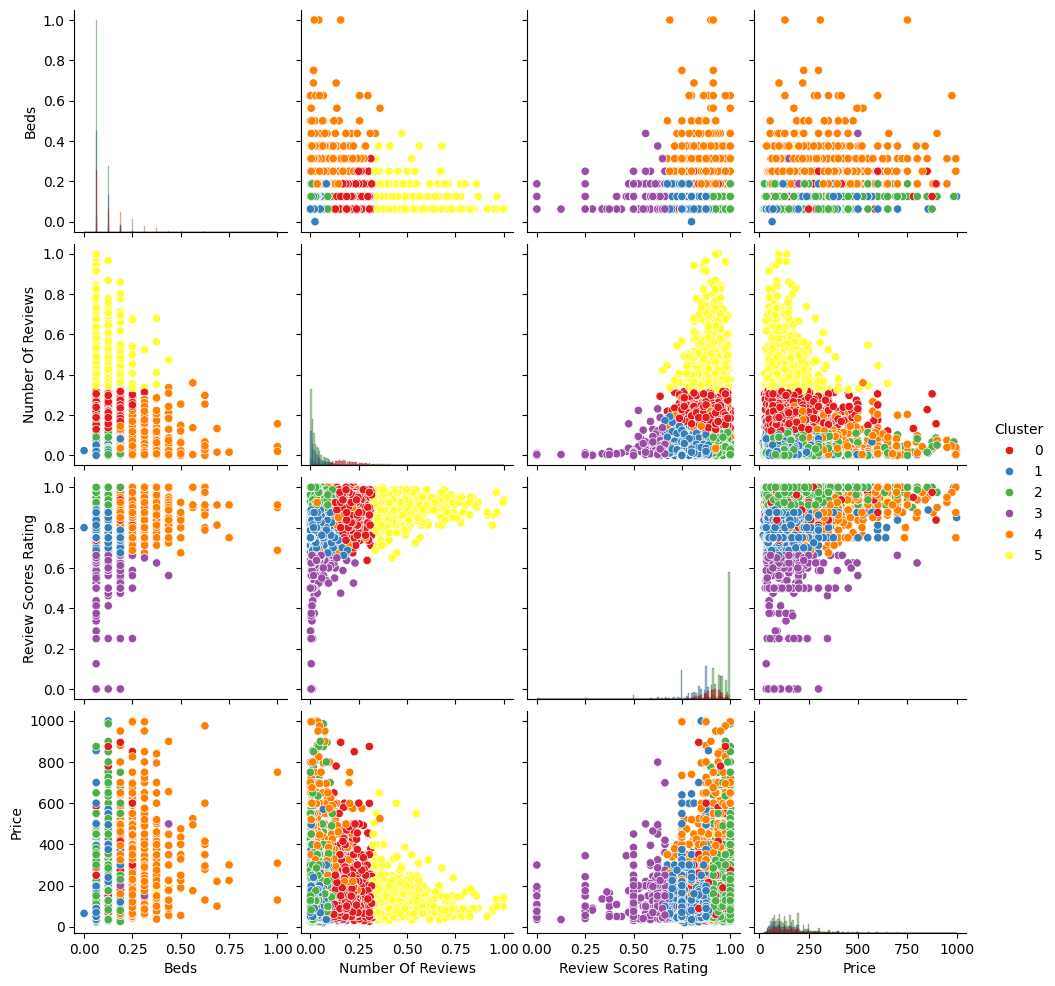

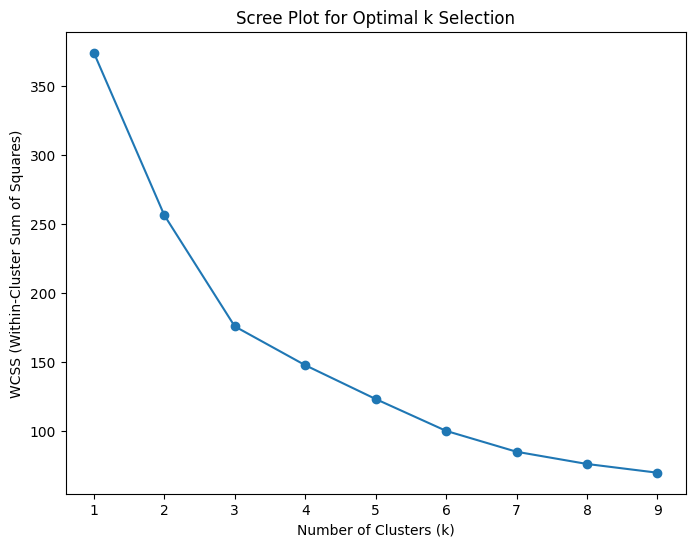

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "airbnb_hw.csv"
df = pd.read_csv(file_path)

# Convert Price to numeric and handle errors
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Select relevant columns and drop NaNs
df_clean = df[['Beds', 'Number Of Reviews', 'Review Scores Rating', 'Price']].dropna()

# Normalize the features (Min-Max Scaling)
scaler = MinMaxScaler()
df_clean[['Beds', 'Number Of Reviews', 'Review Scores Rating']] = scaler.fit_transform(
    df_clean[['Beds', 'Number Of Reviews', 'Review Scores Rating']]
)

# Apply KMeans clustering with k=6
kmeans = KMeans(n_clusters=6, random_state=100, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(df_clean[['Beds', 'Number Of Reviews', 'Review Scores Rating']])

# Compute average rental price for each cluster
cluster_summary = df_clean.groupby('Cluster')['Price'].describe()
print(cluster_summary)

# Generate pairplot to visualize clustering
sns.pairplot(df_clean, hue='Cluster', palette='Set1', diag_kind='hist')
plt.show()

# Compute WCSS for different k values to generate a scree plot
wcss = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=100, n_init=10)
    kmeans.fit(df_clean[['Beds', 'Number Of Reviews', 'Review Scores Rating']])
    wcss.append(kmeans.inertia_)

# Plot scree plot
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Scree Plot for Optimal k Selection")
plt.show()


The cluster with the highest average rent is cluster 4.

           count        mean         std   min   25%    50%    75%    max
Cluster                                                                  
0         2504.0  142.132588   89.456203  22.0  85.0  120.0  175.0  895.0
1        15768.0  155.250824  102.245234  10.0  87.0  130.0  195.0  999.0
2         3788.0  138.182946   97.073734  20.0  70.0  110.0  175.0  995.0


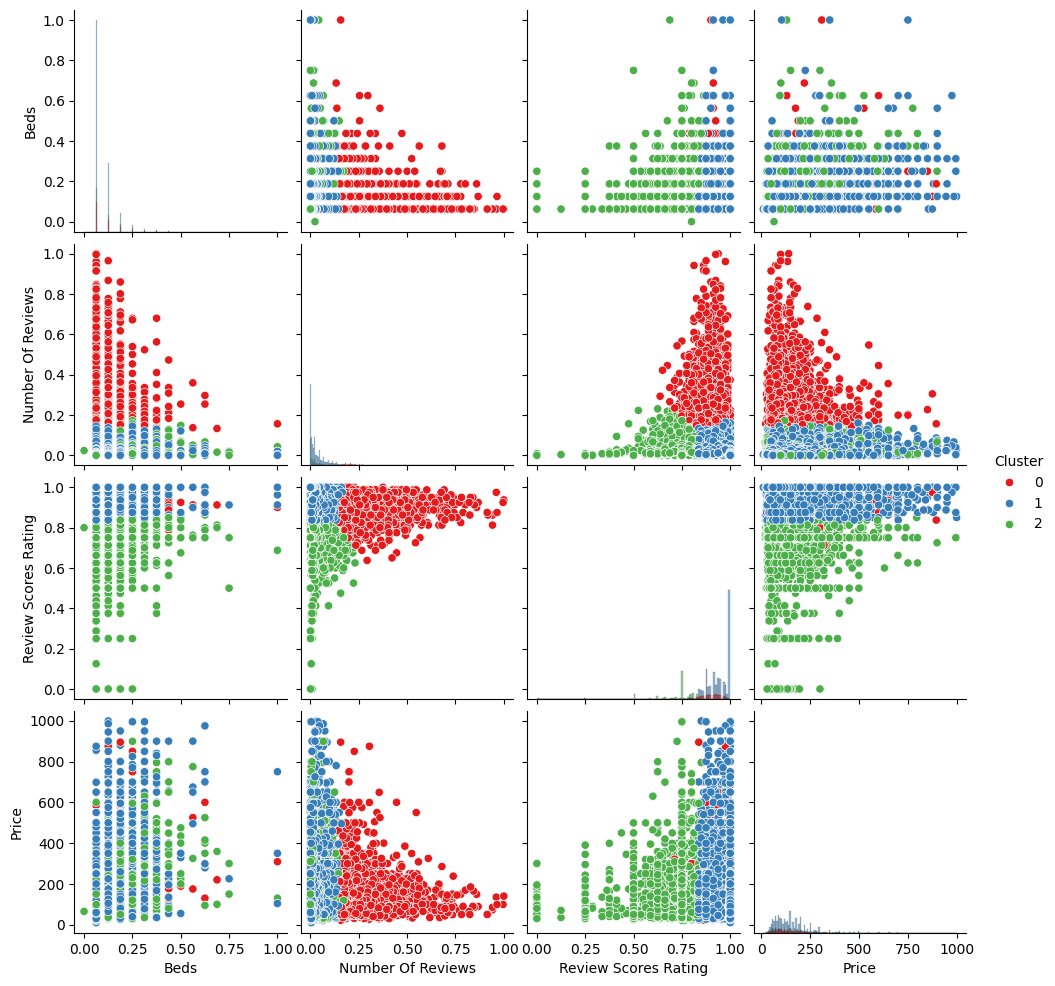

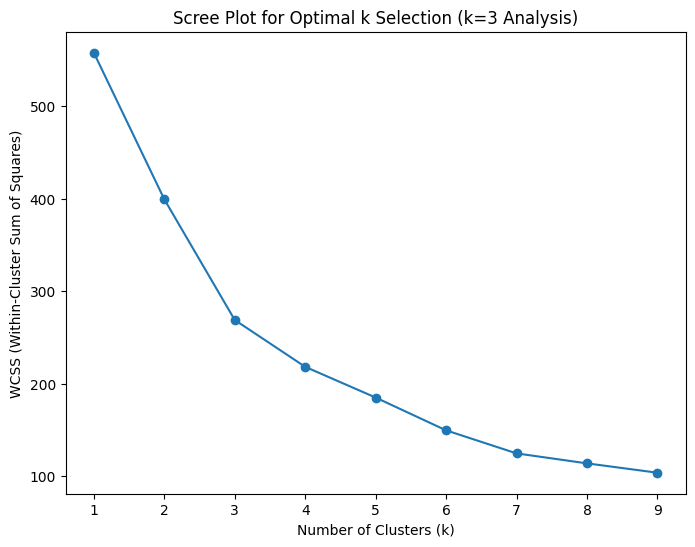

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "airbnb_hw.csv"
df = pd.read_csv(file_path)

# Convert Price to numeric and handle errors
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Select relevant columns and drop NaNs
df_clean = df[['Beds', 'Number Of Reviews', 'Review Scores Rating', 'Price']].dropna()

# Normalize the features (Min-Max Scaling)
scaler = MinMaxScaler()
df_clean[['Beds', 'Number Of Reviews', 'Review Scores Rating']] = scaler.fit_transform(
    df_clean[['Beds', 'Number Of Reviews', 'Review Scores Rating']]
)

# Apply KMeans clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=100, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(df_clean[['Beds', 'Number Of Reviews', 'Review Scores Rating']])

# Compute average rental price for each cluster
cluster_summary = df_clean.groupby('Cluster')['Price'].describe()
print(cluster_summary)

# Generate pairplot to visualize clustering
sns.pairplot(df_clean, hue='Cluster', palette='Set1', diag_kind='hist')
plt.show()

# Compute WCSS for different k values to generate a scree plot
wcss = []
k_values = range(1, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=100, n_init=10)
    kmeans.fit(df_clean[['Beds', 'Number Of Reviews', 'Review Scores Rating']])
    wcss.append(kmeans.inertia_)

# Plot scree plot
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Scree Plot for Optimal k Selection (k=3 Analysis)")
plt.show()
